# **Install**

In [11]:
!pip install progress

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# **Imports**

In [12]:
import numpy as np
from scipy.special import logsumexp
import matplotlib.pyplot as plt
from progress.bar import IncrementalBar
import sys
import time
from keras.datasets import fashion_mnist
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import math

# **Activation Functions**

In [13]:
# derivative function, gets function output as input and computer derivative
class Linear:
    def __init__(self):
        self.__name__ = 'linear'

    def __call__(self, Z):
        return Z

    def derivative(self, Z, *args, **kwargs):
        return 1


class Relu:
    def __init__(self):
        self.__name__ = 'relu'

    def __call__(self, Z):
       
        return Z * (Z > 0)

    def derivative(self, Z, *args, **kwargs):
        return (Z > 0) * 1


class Sigmoid:
    def __init__(self):
        self.__name__ = 'sigmoid'

    def __call__(self, Z):
        return 1 / (1 + np.exp(-Z))

    def derivative(self, Z, *args, **kwargs):
        return Z * (1 - Z)



# stable version of softmax:
class Softmax:
    def __init__(self):
        self.__name__ = 'softmax'

    def __call__(self, Z):
        e = -np.max(Z, axis=1, keepdims=True)
        exp = np.exp(Z + e)
        return exp / np.sum(exp, axis=1, keepdims=True)

    def derivative(self, Z, *args, **kwargs):
        raise Exception('cannot get derivative')


class Tanh:
    def __init__(self):
        self.__name__ = 'tanh'

    def __call__(self, Z):
        return np.tanh(Z)

    def derivative(self, Z, *args, **kwargs):
        return 1 - (np.tanh(Z) ** 2)


sigmoid = Sigmoid
softmax = Softmax
relu = Relu
linear = Linear
tanh = Tanh

In [14]:
class Static_split:
    def __init__(self, test_split=0.2):
        self.test_split = test_split

    def set_data(self, X, y, shuffle=True):
        if shuffle == False:
            p = np.arange(X.shape[0])
        else:
            p = np.random.permutation(X.shape[0])

        split = int(X.shape[0] * self.test_split)
        self.X_test = X[p[:split]]
        self.y_test = y[p[:split]]
        self.X_train = X[p[split:]]
        self.y_train = y[p[split:]]

    def get_test_data(self):
        return self.X_test, self.y_test

    def get_train_data(self):
        return self.X_train, self.y_train


class kfold_split:
    def __init__(self, k=5):
        self.k = k

    def set_data(self, X, y, shuffle=True):
        if shuffle == False:
            p = np.arange(X.shape[0])
        else:
            p = np.random.permutation(X.shape[0])

        self.split = np.random.randint(0, self.k, size=X.shape[0])
        self.X = X
        self.y = y

    def __iter__(self):
        return self.__next__()

    def __next__(self):
        for i in range(self.k):
            yield self.X[self.split != i], self.y[self.split != i], self.X[self.split == i], self.y[self.split == i]

# **Layers**

In [15]:
class Dense:
    def __init__(self, unit, activation=linear, input_dim=0, trainable=True):
        self.unit = unit
        self.__name__ = 'Dense'
        self.name = "dense"
        self.trainable = trainable
        if type(activation) == str:
            if activation.lower() == 'linear':
                activation = Linear()
            elif activation.lower() == 'sigmoid':
                activation = Sigmoid()
            elif activation.lower() == 'relu':
                activation = Relu()
            elif activation.lower() == 'softmax':
                activation = Softmax()
            elif activation.lower() == 'tanh':
                activation = Tanh()
            else:
                raise Exception("Activation function " + activation + " not found!")

        self.activation = activation
        self.input_dim = input_dim

    def set_name(self, name):
        self.name = name

    def compile(self, input_dim=-1):
        if input_dim == -1:
            assert self.input_dim != 0
        else:
            self.input_dim = input_dim

        self.W = (np.random.random(size=(self.input_dim + 1, self.unit))) - 0.5
        self.W = self.W / (self.W.std() * (input_dim + self.unit) ** 0.5)

    def __call__(self, X, activation=True):
        if activation:
            return self.activation(np.dot(np.hstack((X, np.ones((X.shape[0], 1)))), self.W))
        else:
            return np.dot(np.hstack((X, np.ones((X.shape[0], 1)))), self.W)

    def set_trainable(self, trainable):
        self.trainable = trainable

    def update(self, dw):
        # print("self.W.len: ", len(self.W))
        # print("self.W.shape: ", self.W.shape)
        if self.trainable:
            self.W = self.W + dw

    def reset_weights(self):
        self.W = (np.random.random(size=self.W.shape)) - 0.5
        self.W = self.W / (self.W.std() * (self.W.shape[0] + self.unit) ** 0.5)


# **Loss Functions**

In [16]:
class Cross_entropy:
    def __init__(self, last_layer_activation):
        if last_layer_activation == 'sigmoid':
            self.get_loss = self.call_sigmoid
            self.derivative = self.derivative_sigmoid
        elif last_layer_activation == 'softmax':
            self.get_loss = self.call_softmax
            self.derivative = self.derivative_softmax

    def call_sigmoid(self, z, y):
        return np.mean(z * (1 - y) + np.logaddexp(0, -z))

    def derivative_sigmoid(self, h, y):
        return h - y

    def call_softmax(self, z, y):
        return -np.mean(np.sum(y * (z - logsumexp(z, axis=1, keepdims=True)), axis=1))

    def derivative_softmax(self, h, y):
        return h - y

    def get_loss(self, h, y):
        return -np.mean(np.sum(y * np.log(h) + (1 - y) * np.log(1 - h), axis=1))

    def derivative(self, h, y):
        return (h - y) / (h * (1 - h))

    def __call__(self, h, y):
        self.get_loss(h, y)

# **Model**

In [17]:
class Sequential:
    def __init__(self):
        self.remove_last_layer_activation = False
        self.layers = []
        self.loss = None
        self.optimizer = None
        self.regularization = None
        self.layer_counter = 1

    def add(self, layer):
        layer.set_name('dense_' + str(self.layer_counter))
        self.layer_counter += 1
        self.layers.append(layer)

    def initialize_layers(self):
        input_dim = -1
        for layer in self.layers:
            layer.compile(input_dim)
            input_dim = layer.unit

    def compile(self, optimizer='SGD', loss='cross_entropy', regularization=None):
        if loss.lower() == 'cross_entropy':
            self.loss = Cross_entropy(self.layers[-1].activation.__name__)
            if self.layers[-1].activation.__name__ == "sigmoid" or self.layers[-1].activation.__name__ == "softmax":
                self.remove_last_layer_activation = True

        if type(optimizer) == str:
            if optimizer.lower() == 'sgd':
                optimizer = SGD()
            elif optimizer.lower() == 'momentum_sgd':
                optimizer = Momentum_SGD()
            elif optimizer.lower() == 'adagrad':
                optimizer = Adagrad()
            elif optimizer.lower() == 'rmsprop':
                optimizer = RMSprop()
            elif optimizer.lower() == 'adam':
                optimizer = Adam()
            else:
                raise Exception("Optimizer " + optimizer + " not found!")

        if regularization is not None and type(regularization) == str:
            if regularization.lower() == 'l1':
                regularization = L1()
            elif regularization.lower() == 'l2':
                regularization = L2()

        self.regularization = regularization
        self.optimizer = optimizer


        self.initialize_layers()

    def fit(self, X, y, batch_size=32, epoch=1, test_data=None):
        assert self.loss is not None

        history = {'acc': np.zeros(epoch), 'loss': np.zeros(epoch)}
        if test_data is not None:
            history['val_acc'] = np.zeros(epoch)
            history['val_loss'] = np.zeros(epoch)

        for epch in range(epoch):
            print('Epoch', epch + 1)
            sum_loss = 0
            sum_acc = 0
            bt_conter = 0

            required_batchs = int(X.shape[0] / batch_size + 0.99999999)
            bar = IncrementalBar(max=required_batchs,
                                 suffix='%(index)d/%(max)d - %(eta)ds')

            epoch_shufle = np.random.permutation(X.shape[0])

            for bt in range(0, X.shape[0], batch_size):
                bt_conter += 1
                # single batch:
                X_batch = X[epoch_shufle[bt:min(bt + batch_size, X.shape[0])]]
                y_batch = y[epoch_shufle[bt:min(bt + batch_size, X.shape[0])]]

                layer_output = [X_batch]
                for j, layer in enumerate(self.layers):
                    layer_output.append(layer(layer_output[-1]))

                delta_next = self.loss.derivative(layer_output[-1], y_batch)
                if not self.remove_last_layer_activation:
                    delta_next *= self.layers[-1].activation.derivative(layer_output[-1])

                grad = [0 for i in range(len(self.layers))]
                regularization_grad = [0 for i in range(len(self.layers))]
                if self.regularization is not None:
                    regularization_grad = self.regularization.derivative(self.layers)

                for i in range(len(self.layers) - 1, 0, -1):
                    delta_prev = np.dot(delta_next, self.layers[i].W.T[:, :-1]) * \
                                 self.layers[i - 1].activation.derivative(layer_output[i])

                    delta_wi = np.dot(np.hstack((layer_output[i], np.ones((layer_output[i].shape[0], 1)))).T,
                                      delta_next)
                    grad[i] = delta_wi / X_batch.shape[0] + regularization_grad[i]

                    delta_next = delta_prev

                delta_wi = np.dot(np.hstack((layer_output[0], np.ones((layer_output[0].shape[0], 1)))).T, delta_next)
                grad[0] = delta_wi / X_batch.shape[0] + regularization_grad[0]

                self.optimizer.update(grad, self.layers)

                d = self.evaluate(X_batch, y_batch)
                loss, acc = d['loss'], d['acc']
                sum_acc += acc
                sum_loss += loss
                bar.next()
                # sys.stdout.write(" loss: %f acc: %f" % (sum_loss / (bt_conter + 1), sum_acc / (bt_conter + 1)))
                # sys.stdout.flush()

            bar.finish()
            d = self.evaluate(X, y)
            loss, acc = d['loss'], d['acc']
            if test_data is not None:
                d = self.evaluate(test_data[0], test_data[1])
                val_loss, val_acc = d['loss'], d['acc']
                history['val_loss'][epch] = val_loss
                history['val_acc'][epch] = val_acc
                history['loss'][epch] = loss
                history['acc'][epch] = acc
                print('loss: {} acc: {} val_loss: {} val_acc: {}'.format(loss, acc, val_loss, val_acc))
            else:
                history['loss'][epch] = loss
                history['acc'][epch] = acc
                print('loss: {} acc: {}'.format(loss, acc))

        return history

    def predict(self, X, batch_size=32, last_activation=True):
        return np.argmax(self.predict_proba(X, batch_size=batch_size, last_activation=last_activation), axis=1)

    def predict_proba(self, X, batch_size=32, last_activation=True):
        output = np.zeros((X.shape[0], self.layers[-1].unit))

        for i in range(0, X.shape[0], batch_size):
            t = X[i:min(i + batch_size, X.shape[0])].copy()
            for j, layer in enumerate(self.layers):
                t = layer(t, activation=(j != len(self.layers) - 1 or last_activation))

            output[i:min(i + batch_size, X.shape[0])] = t

        return output

    def evaluate(self, X, y, batch_size=32):
        if self.loss is not None:
            p = self.predict_proba(X, batch_size=batch_size, last_activation=not self.remove_last_layer_activation)
            loss = self.loss.get_loss(p, y)
            if self.regularization is not None:
                loss += self.regularization.cost(self.layers)

            if self.remove_last_layer_activation:
                p = self.layers[-1].activation(p)

            pred = np.argmax(p, axis=1)
            y_class = np.argmax(y, axis=1)

            acc = np.sum(pred == y_class) / p.shape[0]
            return {'loss': loss, 'acc': acc}
        else:
            p = self.predict_proba(X, batch_size=batch_size)

            pred = np.argmax(p, axis=1)
            y_class = np.argmax(y, axis=1)

            acc = np.sum(pred == y_class) / p.shape[0]
            return {'acc': acc}

    def summary(self):
        print("_" * 65)
        print('Layer (type)                 Output Shape              Param #')
        print("=" * 65)

        layer_type = 'Input'
        output_shape = '(None, {})'.format(str(self.layers[0].input_dim))
        params = '0'
        print('{:<29}'.format(layer_type) +
              '{:<26}'.format(output_shape) +
              '{}'.format(params))
        print("-" * 65)

        trainable_params = 0
        non_trainable_params = 0

        for l in self.layers:
            layer_type = l.name + ' ({})'.format(l.__name__)
            output_shape = '(None, {})'.format(str(l.unit))
            params = '{}'.format(l.W.shape[0] * l.W.shape[1])

            if l.trainable:
                trainable_params += l.W.shape[0] * l.W.shape[1]
            else:
                non_trainable_params += l.W.shape[0] * l.W.shape[1]

            print('{:<29}'.format(layer_type) +
                  '{:<26}'.format(output_shape) +
                  '{}'.format(params))
            print("-" * 65)

        print('Total params:', trainable_params + non_trainable_params)
        print('Trainable params:', trainable_params)
        print('Non-trainable params:', non_trainable_params)
        print("_" * 65)
        print('Optimizer : {}'.format(self.optimizer.__name__))
        if self.regularization is not None:
            print('Regularization : {}'.format(self.regularization.__name__))
        print("-" * 65)
        print()
        print()

    def save_weights(self, path):
        import os
        try:
            os.rmdir(path)
        except:
            pass

        os.mkdir(path)

        for i, layer in enumerate(self.layers):
            np.save(os.path.join(path, str(i) + '.npy'), layer.W)

    def load_weights(self, path):
        import os
        assert len(os.listdir(path)) == len(self.layers)

        for i, layer in enumerate(self.layers):
            self.layers[i].W = np.load(os.path.join(path, str(i) + '.npy'))

    def reset_weights(self):
        for layer in self.layers:
            layer.reset_weights()


# **Load Dataset**

In [18]:
def load_dataset():
    (x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

    train_mean = x_train.mean()
    train_std = x_train.std()

    # one-hot encoding of y
    y_train = to_categorical(y_train)
    y_test = to_categorical(y_test)

    # flatten Xs:
    x_train = x_train.reshape(x_train.shape[0], -1)
    x_test = x_test.reshape(x_test.shape[0], -1)

    x_train = x_train / 255.0
    x_test = x_test / 255.0

    print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

    split_data = Static_split(test_split=0.2)
    split_data.set_data(x_train, y_train)
    (x_train, y_train) = split_data.get_train_data()
    (X_val, y_val) = split_data.get_test_data()

    return x_train, y_train, x_test, y_test, X_val, y_val

In [19]:
X_train, y_train, X_test, y_test, X_val, y_val = load_dataset()

(60000, 784) (60000, 10) (10000, 784) (10000, 10)


# === Regularization ===

## **L1 Regularization**
complete this part

In [20]:
class L1:
    def __init__(self, lam=0.001):
        self.lam = lam
        self.__name__ = 'L1 Regularization'

    def cost(self, layers):

        cost = 0
        for l in layers:
            cost += np.sum(np.abs(l.W[:-1, :]))

        return cost * self.lam

    def derivative(self, layers):

        dw = [np.zeros(l.W.shape) * self.lam for l in layers]
        for i in range(len(layers)):
            dw[i][:-1, :] = np.sign(layers[i].W[:-1, :]) * self.lam
            
        return dw

## **L2 Regularization**
complete this part

In [21]:
class L2:
    def __init__(self, lam=0.001):
        self.lam = lam
        self.__name__ = 'L2 Regularization'

    def cost(self, layers):

        cost = 0
        for l in layers:
            cost += np.sum(np.square(l.W))

        return cost * self.lam / 2

    def derivative(self, layers):

        derivatives = []
        for l in layers:
            dW = np.zeros(l.W.shape)
            dW = l.W
            derivatives.append(dW * self.lam)
            
        return derivatives

# === Optimizers ===

## **SGD**

In [22]:
class SGD:
    def __init__(self, lr=0.01):
        self.lr = lr
        self.__name__ = 'SGD'

    def update(self, grads, layers):
        for layer, delta in zip(layers, grads):
            layer.update(-delta * self.lr)

sgd = SGD

## **Momentum SGD**

In [23]:
class Momentum_SGD(SGD):
    def __init__(self, lr=0.01, momentum=0.9):
        super().__init__(lr)
        self.momentum = momentum

        # Helping attribute
        self.velocity = None

        self.__name__ = 'Momentum_SGD'

    def update(self, grads, layers):

        if self.velocity is None:
        # initialize velocity
            self.velocity = [np.zeros_like(grad) for grad in grads]

        for i, (layer, delta) in enumerate(zip(layers, grads)):
            self.velocity[i] = self.momentum * self.velocity[i] - self.lr * delta
            layer.update(self.velocity[i])

momentum_sgd = Momentum_SGD

## **Adagrad**
complete this part

In [24]:
class Adagrad:
    def __init__(self, lr=0.01):
        self.global_lr = lr
        self.epsilon = 1e-7
        self.velocity = None
        self.accumulated_gradient = None

        self.__name__ = 'AdaGrad'

    def update(self, grads, layers):

        if self.accumulated_gradient is None:
            self.accumulated_gradient = [np.zeros_like(grad) for grad in grads]
        
        for i, (grad, layer) in enumerate(zip(grads, layers)):
            self.accumulated_gradient[i] += grad ** 2
            rms = np.sqrt(self.accumulated_gradient[i] + self.epsilon)
            delta = -self.global_lr * grad / rms
            layer.update(delta)

adagrad = Adagrad

## **RMSprop**
complete this part

In [25]:
class RMSprop:
    def __init__(self, lr=0.001, rho=0.9):
        self.global_lr = lr
        self.rho = rho
        self.epsilon = 1e-7

        # Helping attribute
        self.velocity = None
        self.accumulated_gradient = None

        self.__name__ = 'RMSprop'

    def update(self, grads, layers):
      
        if self.accumulated_gradient is None:
          self.accumulated_gradient = [np.zeros_like(grad) for grad in grads]

        for i, (grad, layer) in enumerate(zip(grads, layers)):
              self.accumulated_gradient[i] = self.rho*self.accumulated_gradient[i] + (1-self.rho)*(grad ** 2)
              rms_grad = np.sqrt(self.accumulated_gradient[i] + self.epsilon)
              delta = -self.global_lr * grad / rms_grad
              layer.update(delta)

rmsprop = RMSprop

## **Adam**

complete this part

In [26]:
class Adam(Adagrad):
    def __init__(self, lr=0.001, rho_1=0.9, rho_2=0.999):
        self.global_lr = lr
        self.rho_1 = rho_1
        self.rho_2 = rho_2

        self.epsilon = 1e-8

        # Helping attribute
        self.first_moment_estimate = None
        self.second_moment_estimate = None
        self.t = 0
        self.__name__ = 'Adam'

    def update(self, grads, layers):

        if self.first_moment_estimate is None:
          self.first_moment_estimate = [np.zeros_like(grad) for grad in grads]
          self.second_moment_estimate = [np.zeros_like(grad) for grad in grads]
        
        self.t +=1
        for i, (grad, layer) in enumerate(zip(grads, layers)):
            
            self.first_moment_estimate[i] = self.rho_1*self.first_moment_estimate[i] + (1-self.rho_1)*grad
            self.second_moment_estimate[i] = self.rho_2*self.second_moment_estimate[i] + (1-self.rho_2)*(grad**2)

            tempS = self.first_moment_estimate[i]/(1-(np.power(self.rho_1, self.t)))
            tempR = self.second_moment_estimate[i]/(1-(np.power(self.rho_2, self.t)))
            temp1 = np.sqrt(tempR)
            temp = temp1+self.epsilon
            delta = -tempS/temp
            layer.update(self.global_lr *delta)

adam = Adam        

# === ِDifferent Neurons ===

### **SGD Optimizer**/ **L1 regularization**/ **20 Epochs**

### *50 Neuron*

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 50)                39250
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                510
-----------------------------------------------------------------
Total params: 39760
Trainable params: 39760
Non-trainable params: 0
_________________________________________________________________
Optimizer : SGD
Regularization : L1 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 5.392800922426773 acc: 0.7378541666666667 val_loss: 5.401151841498785 val_acc: 0.73525
Epoch 2
loss: 5.007918387407435 acc: 0.7750833333333333 val_loss: 5.014008300603663 val_acc: 0.77625
Epoch 3
loss: 4.6873502795106 acc: 0.7968

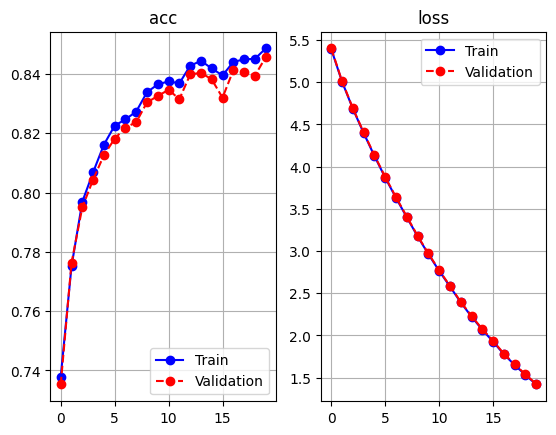

In [27]:
model = Sequential()
model.add(Dense(50, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='sgd', regularization='l1')

model.summary()

first = time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
second =  time.time()
print("time: ", second-first)

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

### *75 Neuron*

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 75)                58875
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                760
-----------------------------------------------------------------
Total params: 59635
Trainable params: 59635
Non-trainable params: 0
_________________________________________________________________
Optimizer : SGD
Regularization : L1 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 6.318016759069963 acc: 0.7587708333333333 val_loss: 6.317738935042776 val_acc: 0.7601666666666667
Epoch 2
loss: 5.804029454640075 acc: 0.7908125 val_loss: 5.803066431839679 val_acc: 0.7916666666666666
Epoch 3
loss: 5.375602201604

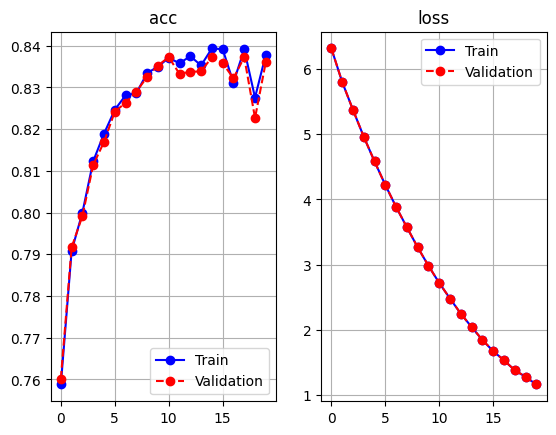

In [28]:
model = Sequential()
model.add(Dense(75, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='sgd', regularization='l1')

model.summary()

first = time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
second =  time.time()
print("time: ", second-first)

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

### *100 Neuron*

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 100)               78500
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                1010
-----------------------------------------------------------------
Total params: 79510
Trainable params: 79510
Non-trainable params: 0
_________________________________________________________________
Optimizer : SGD
Regularization : L1 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 7.082630086014061 acc: 0.7573125 val_loss: 7.095354408718975 val_acc: 0.7519166666666667
Epoch 2
loss: 6.436629128684611 acc: 0.7994583333333334 val_loss: 6.445752065950146 val_acc: 0.7943333333333333
Epoch 3
loss: 5.87606649223

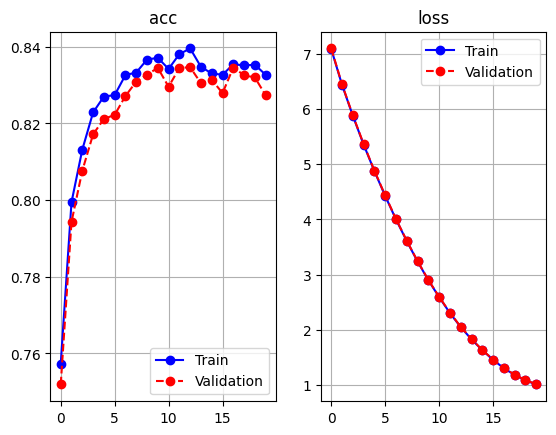

In [29]:
model = Sequential()
model.add(Dense(100, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='sgd', regularization='l1')

model.summary()

first = time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
second =  time.time()
print("time: ", second-first)

plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

# === ِDifferent Optimizer ===



### **50 Neurons**/ **L2 regularization**/ **20 Epochs**

### *Test SGD*


_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 50)                39250
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                510
-----------------------------------------------------------------
Total params: 39760
Trainable params: 39760
Non-trainable params: 0
_________________________________________________________________
Optimizer : SGD
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 1.143593299005237 acc: 0.7491458333333333 val_loss: 1.1535603727833146 val_acc: 0.7486666666666667
Epoch 2
loss: 1.0271850142310663 acc: 0.783125 val_loss: 1.0355312513438066 val_acc: 0.7801666666666667
Epoch 3
loss: 0.9796466901

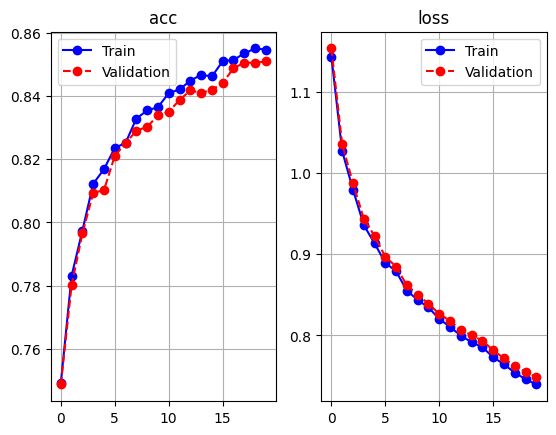

In [30]:
model = Sequential()
model.add(Dense(50, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='sgd', regularization='l2')

model.summary()

first = time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
second =  time.time()
print("time: ", second-first)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

*Test Momentum SGD*

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 50)                39250
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                510
-----------------------------------------------------------------
Total params: 39760
Trainable params: 39760
Non-trainable params: 0
_________________________________________________________________
Optimizer : Momentum_SGD
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.8639774947234053 acc: 0.8271041666666666 val_loss: 0.8766972708934064 val_acc: 0.82025
Epoch 2
loss: 0.7873735988731954 acc: 0.8375 val_loss: 0.8005118272251033 val_acc: 0.8315
Epoch 3
loss: 0.7079767850941039 acc: 0.8

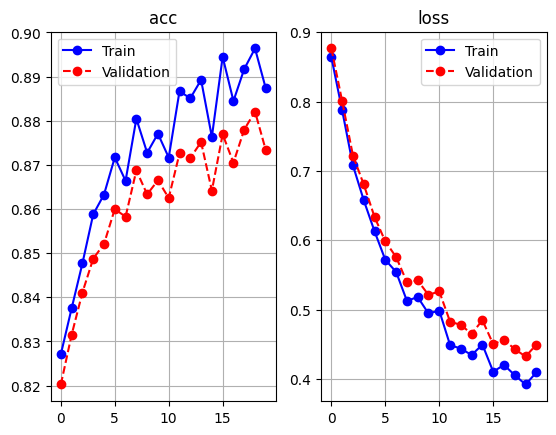

In [31]:
model = Sequential()
model.add(Dense(50, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='momentum_sgd', regularization='l2')

model.summary()

first = time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
second = time.time()
print("Time: ", second-first)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

*Test Adagrad*

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 50)                39250
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                510
-----------------------------------------------------------------
Total params: 39760
Trainable params: 39760
Non-trainable params: 0
_________________________________________________________________
Optimizer : AdaGrad
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.7259128550764214 acc: 0.8365833333333333 val_loss: 0.7321861738570865 val_acc: 0.8335
Epoch 2
loss: 0.661779017218358 acc: 0.8505625 val_loss: 0.6701575651654226 val_acc: 0.8460833333333333
Epoch 3
loss: 0.6318585388244526 

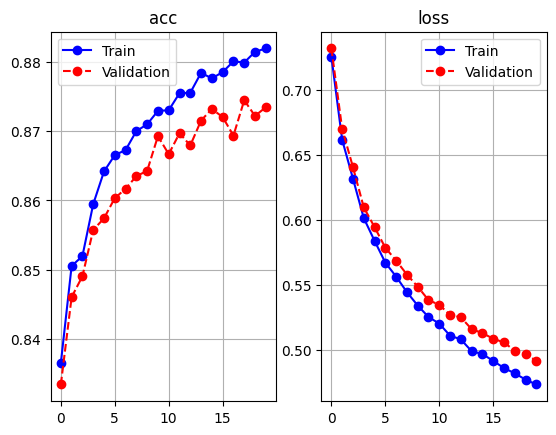

In [32]:
model = Sequential()
model.add(Dense(50, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='adagrad', regularization='l2')

model.summary()

first=time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
second = time.time()
print("Time: ", second-first)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

*Test RMSprop*

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 50)                39250
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                510
-----------------------------------------------------------------
Total params: 39760
Trainable params: 39760
Non-trainable params: 0
_________________________________________________________________
Optimizer : RMSprop
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.710781302726147 acc: 0.8382916666666667 val_loss: 0.7190145172803251 val_acc: 0.8344166666666667
Epoch 2
loss: 0.7130557265322187 acc: 0.8024375 val_loss: 0.7301115933577054 val_acc: 0.79475
Epoch 3
loss: 0.5430962689069145

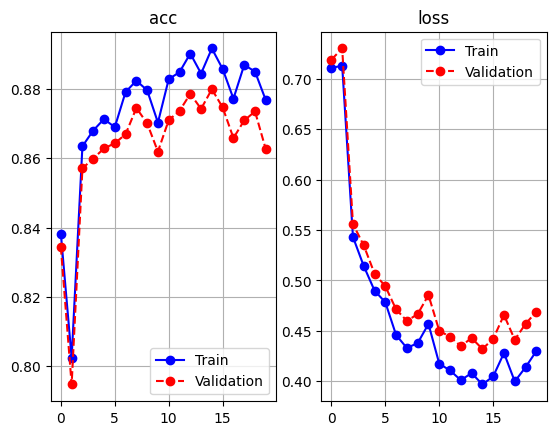

In [33]:
model = Sequential()
model.add(Dense(50, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='rmsprop', regularization='l2')

model.summary()

f = time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
s = time.time()
print("Time: ", s-f)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

*Test Adam*

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 50)                39250
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                510
-----------------------------------------------------------------
Total params: 39760
Trainable params: 39760
Non-trainable params: 0
_________________________________________________________________
Optimizer : Adam
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.6841646119005107 acc: 0.8439375 val_loss: 0.6928831761342902 val_acc: 0.8398333333333333
Epoch 2
loss: 0.5987999282293763 acc: 0.8497083333333333 val_loss: 0.609405293205589 val_acc: 0.8448333333333333
Epoch 3
loss: 0.53386048

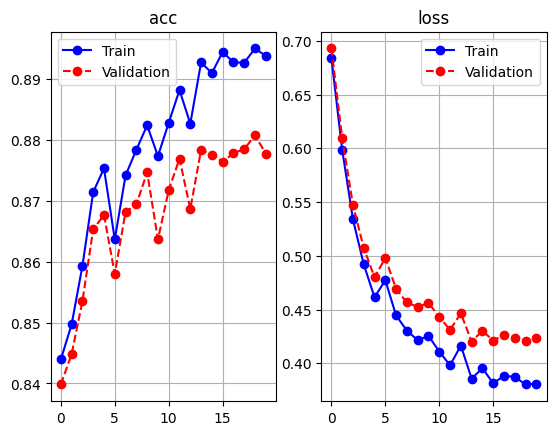

In [34]:
model = Sequential()
model.add(Dense(50, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='adam', regularization='l2')

model.summary()

f = time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
s = time.time()
print("Time: ", s-f)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

# === ِDifferent Regularization ===




**Test Best Optimizer with another regularization**

please use a regularization which hasnot been used already!

*Test adagrad* --> L1 Regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 50)                39250
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                510
-----------------------------------------------------------------
Total params: 39760
Trainable params: 39760
Non-trainable params: 0
_________________________________________________________________
Optimizer : AdaGrad
Regularization : L1 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 1.8032060112500397 acc: 0.8140625 val_loss: 1.8121679253081677 val_acc: 0.8075833333333333
Epoch 2
loss: 1.3552313458449055 acc: 0.8200208333333333 val_loss: 1.361594188194687 val_acc: 0.8153333333333334
Epoch 3
loss: 1.15602

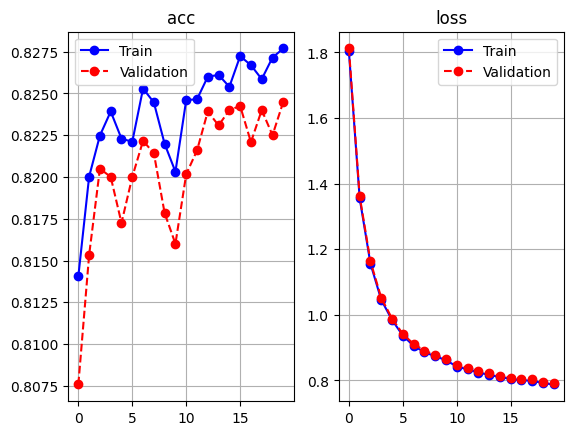

In [43]:
model = Sequential()
model.add(Dense(50, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='adagrad', regularization='l1')

model.summary()

f = time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
s = time.time()
print("Time: ", s-f)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

*Test adagrad* --> L2 Regularization

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 50)                39250
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                510
-----------------------------------------------------------------
Total params: 39760
Trainable params: 39760
Non-trainable params: 0
_________________________________________________________________
Optimizer : AdaGrad
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.7481341479828267 acc: 0.8314375 val_loss: 0.7537178714137195 val_acc: 0.8303333333333334
Epoch 2
loss: 0.6761555098205413 acc: 0.8476875 val_loss: 0.6810598736244102 val_acc: 0.8459166666666667
Epoch 3
loss: 0.6353856629106

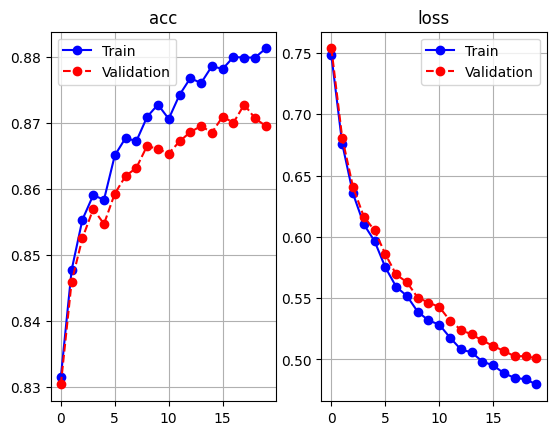

In [44]:
model = Sequential()
model.add(Dense(50, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='adagrad', regularization='l2')

model.summary()

f = time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
s = time.time()
print("Time: ", s-f)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

# Test best model on test data

use your best model and run that on test dataset, report final accuracy

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 50)                39250
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                510
-----------------------------------------------------------------
Total params: 39760
Trainable params: 39760
Non-trainable params: 0
_________________________________________________________________
Optimizer : AdaGrad
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.7474659133686501 acc: 0.8309375 val_loss: 0.7535990049206653 val_acc: 0.8275833333333333
Epoch 2
loss: 0.6807921863179027 acc: 0.84225 val_loss: 0.6861291413689855 val_acc: 0.8406666666666667
Epoch 3
loss: 0.631725040662221

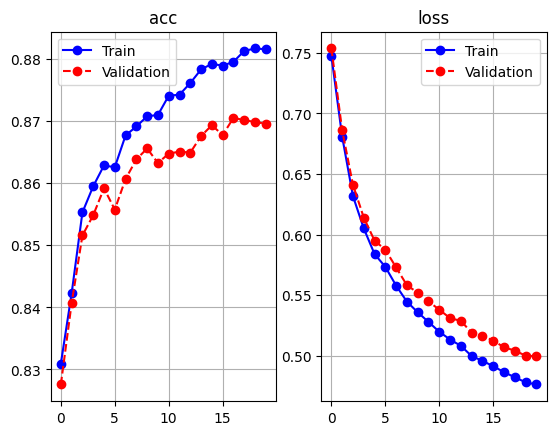

In [45]:
model = Sequential()
model.add(Dense(50, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='adagrad', regularization='l2')

model.summary()

f = time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
s = time.time()
print("Time: ", s-f)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

In [47]:
model.evaluate(X_test, y_test)

{'loss': 0.5243740978476543, 'acc': 0.859}

----

Evaluate Model with Adam Optimizer on Test set

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 50)                39250
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                510
-----------------------------------------------------------------
Total params: 39760
Trainable params: 39760
Non-trainable params: 0
_________________________________________________________________
Optimizer : Adam
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.7038134150445965 acc: 0.8354583333333333 val_loss: 0.711634337544117 val_acc: 0.8325
Epoch 2
loss: 0.5932262614877409 acc: 0.8558333333333333 val_loss: 0.6048982161457195 val_acc: 0.851
Epoch 3
loss: 0.5339875386204109 acc: 0.

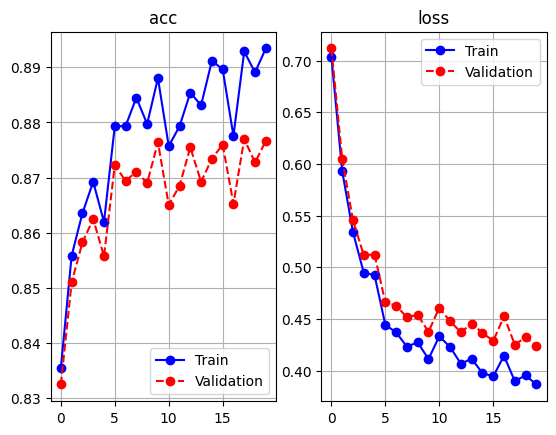

In [48]:
model = Sequential()
model.add(Dense(50, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='adam', regularization='l2')

model.summary()

f = time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
s = time.time()
print("Time: ", s-f)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

In [49]:
model.evaluate(X_test, y_test)

{'loss': 0.45283634875539064, 'acc': 0.8651}

-----

**New Architecture**

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 75)                58875
-----------------------------------------------------------------
dense_2 (Dense)              (None, 50)                3800
-----------------------------------------------------------------
dense_3 (Dense)              (None, 10)                510
-----------------------------------------------------------------
Total params: 63185
Trainable params: 63185
Non-trainable params: 0
_________________________________________________________________
Optimizer : AdaGrad
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.6940871187093139 acc: 0.8354375 val_loss: 0.7006286909847642 val_acc: 0.8340833333333333
Epoch 2


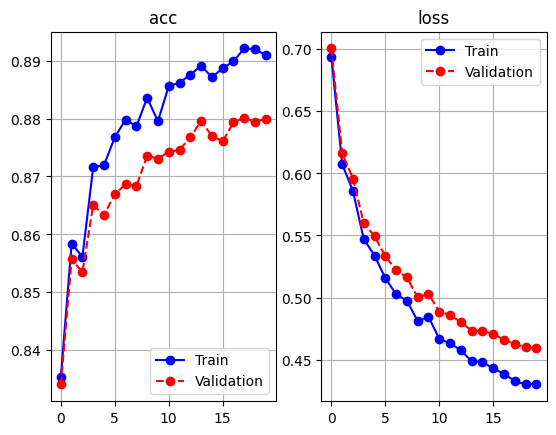

In [61]:
model = Sequential()
model.add(Dense(75, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(50, 'relu'))
# model.add(Dense(50, 'relu'))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='adagrad', regularization='l2')

model.summary()

f = time.time()
history = model.fit(X_train, y_train, epoch=20,
                    batch_size=64, test_data=(X_val, y_val))
s = time.time()
print("Time: ", s-f)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

In [62]:
model.evaluate(X_test, y_test)

{'loss': 0.48961118201672693, 'acc': 0.8677}

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 75)                58875
-----------------------------------------------------------------
dense_2 (Dense)              (None, 10)                760
-----------------------------------------------------------------
Total params: 59635
Trainable params: 59635
Non-trainable params: 0
_________________________________________________________________
Optimizer : AdaGrad
Regularization : L2 Regularization
-----------------------------------------------------------------


Epoch 1
loss: 0.7092973872373549 acc: 0.840125 val_loss: 0.7116768849090704 val_acc: 0.8359166666666666
Epoch 2
loss: 0.6430607538164251 acc: 0.8492291666666667 val_loss: 0.6503016624751514 val_acc: 0.8446666666666667
Epoch 3
loss: 0.60710

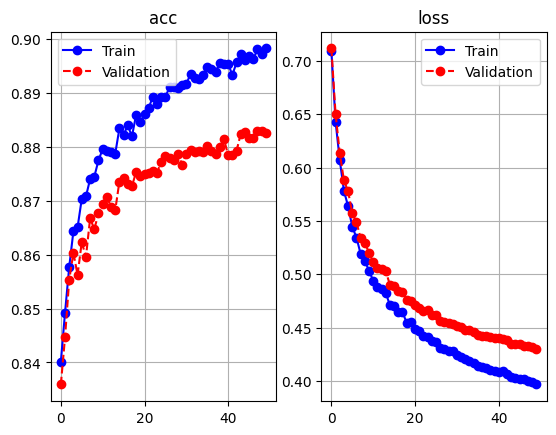

In [59]:
model = Sequential()
model.add(Dense(75, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='adagrad', regularization='l2')

model.summary()

f = time.time()
history = model.fit(X_train, y_train, epoch=50,
                    batch_size=64, test_data=(X_val, y_val))
s = time.time()
print("Time: ", s-f)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

In [60]:
model.evaluate(X_test, y_test)

{'loss': 0.4594265105270959, 'acc': 0.8729}

_________________________________________________________________
Layer (type)                 Output Shape              Param #
Input                        (None, 784)               0
-----------------------------------------------------------------
dense_1 (Dense)              (None, 175)               137375
-----------------------------------------------------------------
dense_2 (Dense)              (None, 75)                13200
-----------------------------------------------------------------
dense_3 (Dense)              (None, 50)                3800
-----------------------------------------------------------------
dense_4 (Dense)              (None, 10)                510
-----------------------------------------------------------------
Total params: 154885
Trainable params: 154885
Non-trainable params: 0
_________________________________________________________________
Optimizer : AdaGrad
Regularization : L2 Regularization
---------------------------------------------------

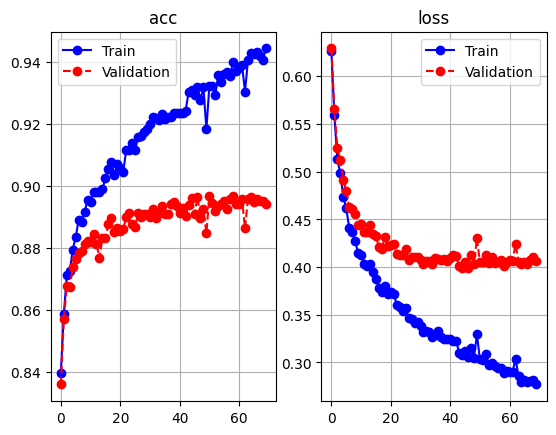

In [63]:
model = Sequential()
model.add(Dense(175, 'relu', input_dim=X_train.shape[1]))
model.add(Dense(75, 'relu'))
model.add(Dense(50, 'relu'))
model.add(Dense(10, 'softmax'))

model.compile(loss='cross_entropy', optimizer='adagrad', regularization='l2')

model.summary()

f = time.time()
history = model.fit(X_train, y_train, epoch=70,
                    batch_size=64, test_data=(X_val, y_val))
s = time.time()
print("Time: ", s-f)
plt.figure()
plt.subplot(1, 2, 1)
plt.title('acc')
plt.plot(history['acc'], 'b-o', label='Train')
plt.plot(history['val_acc'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.subplot(1, 2, 2)
plt.title('loss')
plt.plot(history['loss'], 'b-o', label='Train')
plt.plot(history['val_loss'], 'r--o', label='Validation')
plt.grid()
plt.legend()

plt.show()

In [64]:
model.evaluate(X_test, y_test)

{'loss': 0.4342060006472418, 'acc': 0.8873}